In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

In [4]:
xs = np.arange(-5,5,0.25)

In [5]:
ys = f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

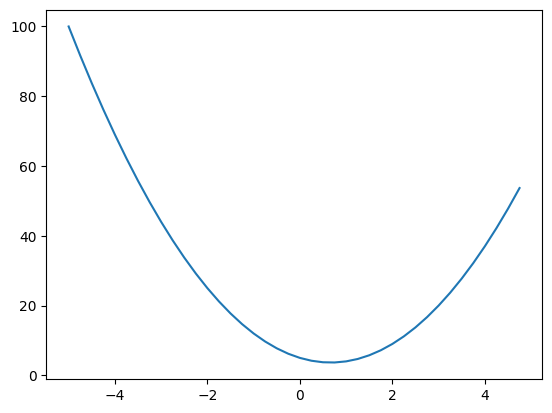

In [6]:
plt.plot(xs,ys)

In [7]:
h = 0.001
x = 3.0
f(x + h)

20.014003000000002

In [8]:
(f(x+h) - f(x)) / h
# 最简单的计算方法，使用定义进行计算

14.00300000000243

In [12]:

a  =2.0
b = -3.0
c = 10.0
d = a*b+c
print(d)

4.0


In [15]:
h = 0.001

a  =2.0
b = -3.0
c = 10.0

d1 = a*b+c
c += h
d2 = a*b+c

print((d2-d1)/h)

0.9999999999994458


In [163]:
class Value:
    def __init__(self, data,_chiledren=(), _op = ' ',label = ' '):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_chiledren)
        self._op = _op
        self.label = label
    
    def __repr__(self) -> str:
        # 让输出更加美观
        return f"Value({self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def backward(): # 定义反向传播函数,闭包
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = backward
        
        return out
    
    def __radd__(self, other): # 右加, 用于处理 2 + Value(3.0) 这种情况
        return self.__add__(other)
    
    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other): # 右减, 用于处理 2 - Value(3.0) 这种情况
        return self.__sub__(other)
    
    def __neg__(self): # 负号, 用于处理 -Value(3.0) 这种情况
        return self*(-1)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data,(self, other), '*')
        def backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = backward
        return out
    
    def __rmul__(self, other): # 右乘, 用于处理 2 * Value(3.0) 这种情况
        return self * other
    
    def __pow__(self, power): # 乘方, 用于处理 Value(3.0) ** 2 这种情况
        if isinstance(power, Value):
            power = power.data
        assert isinstance(power, (int, float)),"Only float or int is allown now" # 确保 power 是 int 或 float
        out = Value(self.data ** power, (self,), '**')
        def backward():
            self.grad += power * self.data ** (power - 1) * out.grad
        out._backward = backward
        return out

    def __truediv__(self, other): # 除法, 用于处理 Value(3.0) / 2 这种情况
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data / other.data, (self, other), '/')
        def backward():
            self.grad += 1.0 / other.data * out.grad
            other.grad += -self.data / other.data ** 2 * out.grad
        out._backward = backward
        return out

    def exp(self):
        out = Value(math.exp(self.data), (self,), 'exp')
        def backward():
            self.grad += math.exp(self.data) * out.grad
        return out

    def tanh(self):
        out = Value(math.tanh(self.data), (self,), 'tanh')
        def backward():
            self.grad += (1.0 - out.data ** 2) * out.grad
        out._backward = backward
        return out

    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for v in reversed(topo):
            v._backward()


In [42]:
a = Value(2.0, label = 'a')
b = Value(-3.0,label = 'b')
c = Value(10.0, label = 'c')

e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(3.0, label = 'f')
L = f*d; L.label = 'L'

In [39]:
from graphviz import Digraph

def trace(root):
    nodes ,edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir':'LR'}) # 从左到右
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label= "{%s | %.4f | grad %.4f}" % (n.label, n.data,n.grad), shape='record')
        if n._op!=' ': # 如果不是根节点
            dot.node(name=uid+n._op, label=n._op)
            dot.edge(uid+n._op, uid)

    for n,m in edges:
        dot.edge(str(id(n)), str(id(m)) + m._op)

    return dot



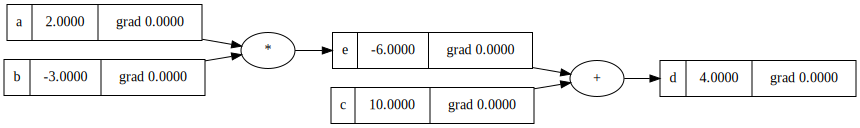

In [40]:
draw_dot(d)

## SUMMARY
至此，已经实现了forward部分，并记录下了数据的计算过程形成了一个计算图

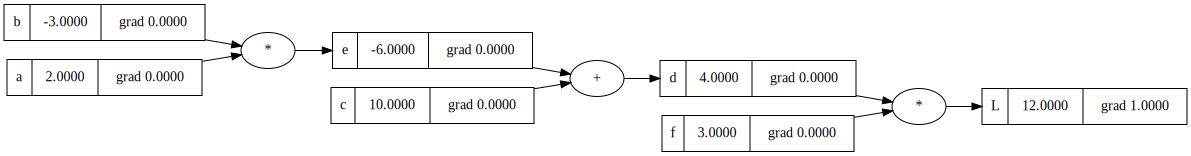

In [45]:
draw_dot(L)

In [41]:
def lol():
    a = Value(2.0, label = 'a')
    b = Value(-3.0,label = 'b')
    c = Value(10.0, label = 'c')

    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(3.0, label = 'f')
    L = f*d; L.label = 'L'
    L1 = L.data

    a = Value(2.0+h, label = 'a')
    b = Value(-3.0,label = 'b')
    c = Value(10.0, label = 'c')

    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(3.0, label = 'f')
    L = f*d; L.label = 'L'
    L2 = L.data
    
    print((L1-L2)/h)

lol()

9.000000000000341


In [44]:
L.grad = 1.0

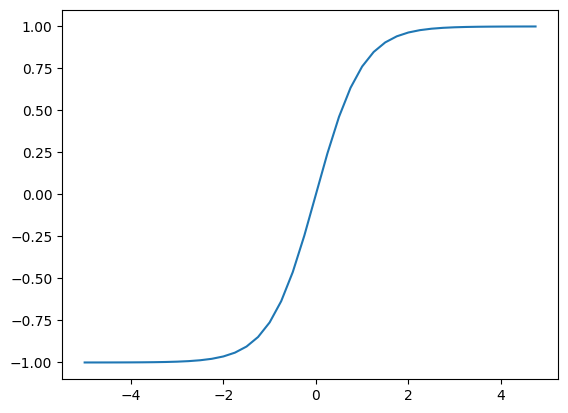

In [49]:
plt.plot(np.arange(-5,5,0.25),np.tanh(np.arange(-5,5,0.25)), label = 'f(x)')

In [89]:
x1 = Value(2.0, label='x1')
x2 = Value(-3.0, label='x2')

w1 = Value(3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(1.0, label='b')
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o' # 还没有完善好加减乘除指数等基本运算，所以先用一个tanh函数来代替

tanh:
$$\tanh(x) = \frac{{e^x - e^{-x}}}{{e^x + e^{-x}}}$$
导数：
$$\frac{d\tanh(x)}{dx} = 1 - (\tanh(x))^2$$

In [70]:
o.backward()

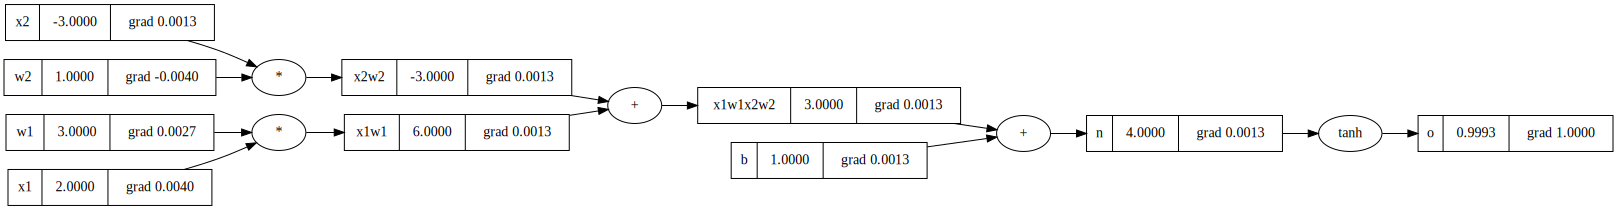

In [73]:
draw_dot(o)

## SUMMARY
自此，我们已经完成了自动求导的一小部分，但是还是需要手工逐个调取backward函数，为了完全自动化求导，需要对计算图进行拓扑排序，确保求导先后顺序，然后自动求导

In [65]:
topo = []
visited = set()

def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(1.0),
 Value(-3.0),
 Value(1.0),
 Value(-3.0),
 Value(3.0),
 Value(2.0),
 Value(6.0),
 Value(3.0),
 Value(4.0),
 Value(0.999329299739067)]

In [66]:
o.grad = 1.0
for v in reversed(topo):
    v._backward()

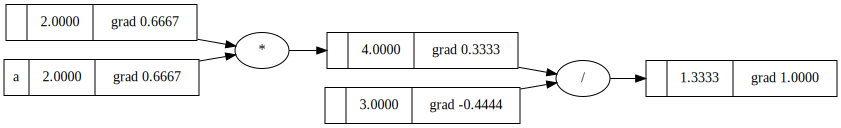

In [90]:
a  = Value(2.0, label = 'a')
b = 2 * a
c = b / 3.0
c.backward()
draw_dot(c)

In [92]:
o = ((2*n).exp() - 1) / ((2*n).exp() + 1) 
# 实现多少算子取决于自己，可以只实现基础算子加减乘除，然后通过这些基础算子来实现其他算子，
# 对于一些较为常用的算子，可以直接实现，比如tanh，exp等

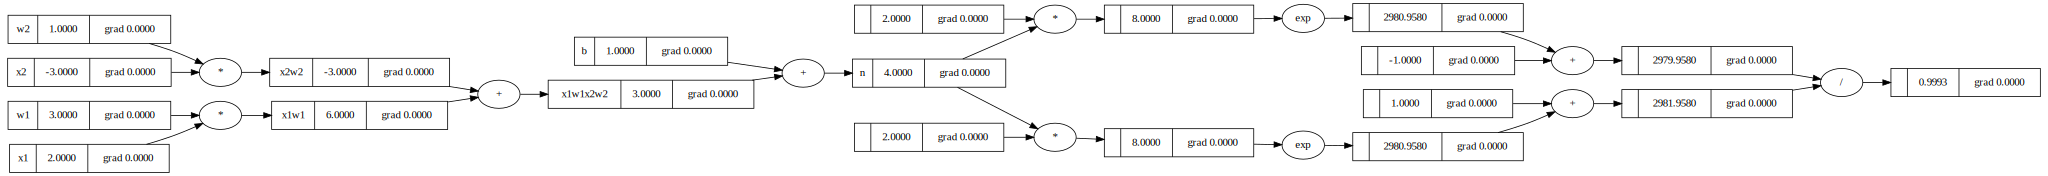

In [93]:
draw_dot(o)

In [94]:
import torch as tr

w1 = tr.tensor(2.0, requires_grad=True)
w2 = tr.tensor(1.0, requires_grad=True)
x1 = tr.tensor(2.0, requires_grad=True)
x2 = tr.tensor(-3.0, requires_grad=True)
b = tr.tensor(1.0, requires_grad=True)

n = x1*w1 + x2*w2 + b
o = tr.tanh(n)

print(o.data.item())
o.backward()

print(w1.grad.item(), w2.grad.item(), x1.grad.item(), x2.grad.item(), b.grad.item())

0.9640275835990906
0.14130163192749023 -0.21195244789123535 0.14130163192749023 0.07065081596374512 0.07065081596374512


In [195]:
import random

class Neuron:
    def __init__(self,in_num) -> None:
        self.w = [Value(random.uniform(-1,1)) for _ in range(in_num)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        temp = sum([wi*xi for wi,xi in zip(self.w,x)], self.b) # zip函数将多个迭代器一一对应拼接成一个新的迭代器
        act = temp.tanh() # 激活函数
        return act

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self,in_num,out_num) -> None:
        self.neurons = [Neuron(in_num) for _ in range(out_num) ]

    def __call__(self, x):
        outs = [neuron(x) for neuron in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self,in_num, out_num) -> None:
        self.Layers = [Layer(in_num, 8), Layer(8, 4), Layer(4, out_num)]
    
    def __call__(self, x):
        for layer in self.Layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.Layers for p in layer.parameters()]

x = [Value(2.0), Value(-3.0)]
model = MLP(2,1)
out = model(x)

In [ ]:
draw_dot(out)

In [207]:
xs = [
    [2.0,3.0,-1.0],
    [3.0,-1.0,0.5],
    [0.5,1.0,1.0],
    [1.0,1.0,-1.0]
]
ys = [1.0, -1.0, -1.0, -1.0]
model = MLP(3,1)
y_pred = [model(x) for x in xs]

In [208]:
loss = sum([(y - yp) ** 2 for y, yp in zip(ys, y_pred)])
loss

Value(3.6392788446911033)

In [ ]:
draw_dot(loss)

In [209]:
loss.backward()

In [214]:
print(loss.data)
for k in range(20):
    y_pred = [model(x) for x in xs]
    loss = sum([(y - yp) ** 2 for y, yp in zip(ys, y_pred)])
    loss.backward()
    for p in model.parameters():
        p.data -= 0.1 * p.grad
        p.grad = 0.0
    print(k,"\t",loss.data)

0.007823167179889868
0 	 0.007554502853946573
1 	 0.007303940779650121
2 	 0.007069704009035983
3 	 0.006850241119128975
4 	 0.006644191510693285
5 	 0.006450356925506149
6 	 0.006267677919349664
7 	 0.006095214312820526
8 	 0.0059321288566060015
9 	 0.0057776735108664755
10 	 0.005631177863210627
11 	 0.0054920393061214665
12 	 0.00535971466962804
13 	 0.005233713063690575
14 	 0.005113589731006094
15 	 0.004998940747608111
16 	 0.004889398437880476
17 	 0.004784627394064505
18 	 0.004684321009254533
19 	 0.004588198448207934


In [215]:
print([model(x) for x in xs])

[Value(0.9425233902893452), Value(-0.9964127456363888), Value(-0.9889459544519489), Value(-0.9674826044692753)]
